In [12]:
from tqdm import tqdm
import time
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
from datetime import datetime
import math
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_palette(sns.color_palette('muted'))
sns.set(color_codes=True, rc={'figure.figsize':(15, 5)})

## 1. Quelques rappels de TDA

#### ToDo

- Rappel de persistent homology

- Rappel persistent diagrams: def + pptés (stabilité etc..)

- Rappel persistence landscapes: def + pptés (continuité, 1-Lip, stabilité etc..)

## 2. La méthode 

Dans ce notebook, nous allons utiliser des **outils** induits par la **TDA** pour **analyser** des **séries temporelles** et tenter de retrouver des comportements **chaotiques** à partir de **features topologiques**. Détaillons alors la **méthode** que nous allons adopter pour construire, à partir d'une série temporelle multivariée $(x_n)_{n \in \{0,...,N-1\}}$ où $\forall n \geq0, \, x_n = (x_n^1, ..., x_n^d) \in \mathbb{R}^d$, ces features topologiques. Pour toute la suite, on suppose que l'on dispose de $N$ échantillons de la série temporelle $(x_n)_{n \in \{0,...,N-1\}}$. 

Cette section est légèrement **technique** car elle introduit un nombre important de **notations** mais elle est indispensable au lecteur s'il veut bien comprendre comment nous avons pu construire numériquement des features topologiques à partir de nos séries temporelles. Cette description de la méthode utilisée est notamment un peu plus **exhaustive** que celle présentée dans l'article.

#### Étape 1: construction des nuages de point

Pour construire des features topologiques à partir de notre série temporelle, nous devons construire à partir de celle ci des **nuages de points** plongés dans un **espace métrique**. Ici, cet espace métrique est $\mathbb{R}^d$ muni de sa structure euclidienne, où $d$ est la dimension de la série temporelle.

On fixe une **taille de fenêtre** $w \in \mathbb{N}^*$ et on en déduit une suite de $m=N-w+1$nuage de points $\{\hat{X}_1, ..., \hat{X}_m\}$ où $\forall i \in \{1, ..., m\}, \, \hat{X}_i = \{x_{t_i}, ..., x_{i + w - 1}\} \subset \mathbb{R}^d$.  
Par exemple, $\hat{X}_0 = \{x_{0}, ..., x_{w -1}\} \subset \mathbb{R}^d$. Moralement, on construit chaque nuage de point en appliquant à la série temporelle une **fenêtre glissante** de **taille $w$** et de **chevauchement $w-1$**. 



#### Étape 2: construction des diagrammes de persistences

On construit alors le **diagramme de persistence** de chacun des nuages de points $\{\hat{X}_1, ..., \hat{X}_m\}$, notés $\{\mathrm{dgm}(\hat{X}_1), ..., \mathrm{dgm}(\hat{X}_m)\}$. Pour tout $i \in \{1, ..., m\}, \, \mathrm{dgm}(\hat{X}_i)$ est construit à partir de la **filtration de Vietoris-Rips** $R(\hat{X}_i, \epsilon)_{\epsilon > 0}$. Comme on tend à manipuler un nombre important de points, les filtrations définies à partir des $\alpha-$complexes sont inenvisageables ici car elles seraient bien trop couteuses. La filtration de Vietoris-Rips est la plus adaptée à ce type de problème. 

De plus, on note que comme on ne va calculer que la **peristent homology** de **dimension 1**, qui correspond au nombre de cycles de dimension 1 indépendants et non équivalent à la frontière d'une chaîne de dimension 2, on ne **calcule** la **filtration** de Vietoris-Rips que **jusqu'aux simplexes de dimension 2**, i.e jusqu'aux aux triangles. La peristent homology de dimension 0 peut aussi être calculée à partir de cette filtration, puisque l'on a accès aux simplexes de dimension 0 et 1. Le calcul des simplexes de dimension 3, i.e les tétraèdres, servirait lui à calculer la persistent homology de dimension 2 et s'avérerait bien plus couteux.

#### Étape 3: construction des persistent landcapes

Puis, on construit le **persistent landscape** associés à la peristent homology de dimension 1 de chacun des diagrammes construits à l'étape précédente $\{\mathrm{dgm}(\hat{X}_1), ..., \mathrm{dgm}(\hat{X}_m)\}$. On les note $\{\lambda(\hat{X}_1, \cdot), ..., \lambda(\hat{X}_m, \cdot)\}$. 

Rappelons que chaque persistence landscape est une **suite de fonction** de la variable réeelle à valeur dans $[0,1]$, i.e $\forall i \in \{1, ..., m\}, \, \lambda(\hat{X}_i, \cdot) = (\lambda_k(\hat{X}_i, \cdot))_{k\in\mathbb{N^*}}$ où $\forall k\in\mathbb{N}^*, \,  \lambda_k(\hat{X}_i, \cdot) : \mathbb{R}^+ \rightarrow [0,1]$.  
Généralement, on fixe un entier $K$ en et on calcule uniquement les $K$ premiers persistence landscapes $(\lambda_k(\hat{X}_i, \cdot))_{k\in\{1, ..., K\}}$. Pour la suite, c'est ce que l'on suppose.

De plus, chaque persistence landscape numéro $k\in\{1, ..., K\}$ est une fonction continue sur $\mathbb{R}^+$ à support compact et 1-Lipschitzienne, on peut donc aisément l'**approcher numériquement** par ses **valeurs prises** sur une **grille régulière** assez grande, i.e une subdivision d'un intervalle $I \subset \mathbb{R}^+$ contenant son support.

Supposons alors que l'on dispose d'une telle grille $t = (t_1, ..., t_q)$, on assimile alors pour tout $i \in \{1, ..., m\}$ et tout  $k \in \{1, ..., K\}, \,  \lambda_k(\hat{X}_i, \cdot)$ au vecteur $\tilde{\lambda_k}(\hat{X}_i) = (\lambda_k(\hat{X}_1, t_1), ..., \lambda_k(\hat{X}_1, t_q)) \in \mathbb{R}^q$. On dispose ainsi, pour tout $i \in \{1, ..., m\}$, d'une **approximation vectorielle** de chacun des persistence landscapes $(\lambda_k(\hat{X}_i, \cdot))_{k\in\{1, ..., K\}}$.

#### Étape 4: calcul des normes de persistent landcapes

On calcule enfin, pour pour chacun de ces persistence landscapes, sa **norme** $L_p$.  
Rappellons que ces normes sont des normes fonctionelles, c'est à dire que, pour tout $i \in \{1, ..., m\}$ et tout  $k \in \{1, ..., K\}, \,  \|\lambda_k(\hat{X}_i, \cdot)\|_p = \left(\int_{\mathbb{R^+}} |\lambda_k(\hat{X}_i, t)|^p dt \right)^{\frac{1}{p}}$ et $\|\lambda(\hat{X}_i, \cdot)\|_p = \left(\sum_{k=1}^{K} \|\lambda_k(\hat{X}_i, \cdot)\|_p^p\right)^{\frac{1}{p}}$.

Ici, nous allons utiliser les **approximation vectorielles** sur la grille régulière de ces persistence landscapes pour approcher leur norme $L_p$.  
Précisemment, pour tout $i \in \{1, ..., m\}$ et tout  $k \in \{1, ..., K\}$ on approxime $ \|\lambda_k(\hat{X}_i, \cdot)\|_p \approx \|\tilde{\lambda_k}(\hat{X}_i)\|_p = \left(\sum_{j=1}^q |\lambda_k(\hat{X}_1, t_j)|^p\right)^{\frac{1}{p}}$ et donc $\|\lambda(\hat{X}_i, \cdot)\|_p \approx \left(\sum_{k=1}^{K} \|\tilde{\lambda}_k(\hat{X}_i, \cdot)\|_p^p\right)^{\frac{1}{p}} = \left(\sum_{k=1}^{K}\sum_{j=1}^q |\lambda_k(\hat{X}_i, t_j)|^p\right)^{\frac{1}{p}}$.

Cette approximation revient en fait à approximer chacune des normes $L_p$ par son **intégrale de Riemmann**, à multplication par la taille de la grille régulière près. Comme nous l'avons précisé, chaque persistence landscape est une fonction continue sur $\mathbb{R}^+$ à support compact et 1-Lipschitzienne, ce type d'approximation est donc parfaitement adaptée au problème, elle est d'ailleurs faite dans la majorité de la littérature.

Pour les expériences, on utilise $p=1,2$, ce qui nous donne alors deux séries temporelles à $m$ échantillons:

\begin{align}
	\begin{cases}
		\lambda^1 = (\|\lambda(\hat{X}_1, \cdot)\|_1, ..., \|\lambda(\hat{X}_m, \cdot)\|_1) 		 \\
		\lambda^2 = (\|\lambda(\hat{X}_1, \cdot)\|_2, ..., \|\lambda(\hat{X}_m, \cdot)\|_2) 		
	\end{cases}
\end{align}

Notons que l'on a utilisé la notations $\lambda^p$ et non $\lambda_p$ afin qu'il n'y ait pas de confusions sur l'indice $p$ qui correspond ici à la norme que l'on utilise et non au numéro du persistent landscape.

Le but est alors de voir si, à partir de ces **deux séries temporelles**, on peut retrouver le comportement **chaotique** (associé à des crashs boursiers) de la **série temporelle muti-variée initiale** $(x_n)_{n \in \{0, ..., N-1\}}$ !

## 3. Quelques fonctions utiles pour la TDA

Nos implémentation se basent fortement sur l'utilisation de la **libraire** [Gudhi](https://gudhi.inria.fr), fournissant l'implémentation de nombreux objets de TDA. Toutefois, certains objets sont calculés à partir d'**implémentations personnelles** n'utilisant pas cette librairie.

Précisons alors quelles objets sont calculés à partir de cette **libraire** et quelles objets sont calculés à partir d'**implémentations personnelles**.

#### Calculs des diagrames de persistence

Les **calculs de diagrammes de persistence** sont effectués grâce de la **libraire** [Gudhi](https://gudhi.inria.fr).   

Avec cette librairie, les calculs des persistence diagrams sont effectués à partir de matrices encodant la filtration du complexe simpliciel et évoluant à mesure qu'elle croît. Comme la filtration de Vietoris-Rips est similaire à un graphe de voisinnage, les matrices manipulés sont en quelques sortes des matrices d'adjacences et de simples opérations sur leur colonnes permettent d'encoder la naissance et mort de features topologiques de différentes dimensions. 

#### Calculs des persistence landscapes

Les **calculs de persistence landscapes** sont effectués à partir d'une **implémentation personnelle**. La libraire [Gudhi](https://gudhi.inria.fr) fournit  une implémentation de ces persistence landscapes (surement plus optimale que la nôtre) afin d'avoir une meilleur intuition de ces objets.  

Cette implémentation se base sur l'idée de **distrétiser** chacun des persistence landscape sur une **grille régulière**, comme détaillé dans la section précédente. 

#### Calculs des nuages de points

Les **calculs des nuages de point** sont effectués à partir d'une **implémentation personnelle**, comme ils ne présentent pas de grande difficulté. La libraire [Gudhi](https://gudhi.inria.fr) fournit également de nombreuses façon de calculer des nuages de points à partir de séries temporelles, mais nous avons choisi de ne pas les utiliser.

In [2]:
def compute_pt_clouds(time_serie, window_size):
    """
    Compute a sequence of m (= N - w + 1) point clouds each containing w (= window_size) point in R^d from  N samples of a d-dimensional multi-variate time serie.
    Arguments:
      time_serie: np.array, size N x dim, N samples of a d-dimensional multi-variate time serie 
      window_size: int, window size to construct a point cloud from the time serie
    Returns:
      np.array, size m x w x dim, array of point clouds
    """
    N = len(time_serie)
    return np.array([time_serie[ii : ii + window_size, :] for ii in range(N-window_size+1)])
        

def compute_diagram(pt_cloud, max_dimension=2, max_edge_length=100.0, verbose=False):
    """
    Get the (ONE) persistence diagram of a given point cloud. 
    Peristence is computed for 0-dimensional and 1-dimensional homology, from the Vietoris-Rips filtration.
    Arguments:
      pt_cloud: np.array, size m x w x dim, array of m points clouds of w points embedded in R^d
      max_dimension: int, maximal dimension of simplices considered in the computation of the Vietoris-Rips filtration
      max_edge_length: float, maximal length of an edge in the simplcial complex induced by the Vietoris-Rips filtration      
    Returns:
      diag: persistence diagram (Gudhi format), the persistence diagram
                                                diag[i][j] encodes the lifetime of the j-th topological feature of the i-th diagram
                                                diag[i][0] = dimension (in the sens of persistent homology) of the i-th topological feature 
                                                diag_list[i][1][0] = birth of the i-th topological feature 
                                                diag_list[i][j][1][0] = death of the j-th topological feature of the i-th diagram
    """     
    # compute the Vietoris-Rips filtration
    rips_complex = gd.RipsComplex(pt_cloud, max_edge_length=max_edge_length)
    st = rips_complex.create_simplex_tree(max_dimension=max_dimension) 

    # compute persistence diagram
    diag = st.persistence()
        
    if verbose:    
        end = time.time()            
        print(f"Done!")
        print(f"Running time: {round(end-start, 5)}s.")
    
    return diag
    
def compute_diagrams(pt_clouds, max_dimension=2, max_edge_length=100.0, verbose=False):
    """
    Get the m (MULTIPLE) persistence diagrams of each point cloud in pt_clouds. 
    Peristence is computed for 0-dimensional and 1-dimensional homology, from the Vietoris-Rips filtration.
    Arguments:
      pt_cloud: np.array, size m x w x dim, array of m points clouds of w points embedded in R^d
      max_dimension: int, maximal dimension of simplices considered in the computation of the Vietoris-Rips filtration
      max_edge_length: float, maximal length of an edge in the simplcial complex induced by the Vietoris-Rips filtration      
    Returns:
      diag_list: list of diagrams persistence diagrams (Gudhi format), diag_list[i] is the persistent diagram of the i-point cloud in the Gudhi format 
    """
    if verbose:
        print("Computation of the persistence diagrams...")
        start = time.time()
    diag_list = []
    
    # loop over the point clouds
    for ii in range(len(pt_clouds)):
        
        # compute and store persistence diagram
        diag = compute_diagram(pt_clouds[ii], max_edge_length=max_edge_length)
        diag_list.append(diag)
        
    if verbose:    
        end = time.time()            
        print(f"Done!")
        print(f"Running time: {round(end-start, 5)}s.")
    
    return diag_list

def to_array_diag(diag_list):
    """
    Map a persistence diagram on the Gudhi format, i.e list of tuples of tuples to array.
    diag is a list of tuples of the form: (homology_dim, (birth, death)) encodes topological feature's lifetime.
    This function was used for some manipulations of diagrams, it might not be used directly in the notebook.
    Arguments:
      diag: persistence diagram (Gudhi format), the persistence diagram that needs to be converted
    Returns:
      np.array, the converted persistence diagram
    """
    f = lambda diag: list(map(lambda x: [x[0], x[1][0], x[1][1]], diag))
    return np.asarray(list(map(f , diag_list)))

def landscape_approx(diag, p_dim=1, x_min=0, x_max=5, nb_nodes=500, nb_ld=5):
    """
    Compute a dicretization of the first nb_ld landscape of a p_dim-dimensional persistence diagram
    on a regular grid which on the interval [x_min, x_max] of nb_nodes points.
    This function computes the persistent landscapes for a unique diagram 'diag' so for a unique point cloud.
    Parameters:
      diag: persistence diagram (Gudhi format), the persistence diagram 
      p_dim: int, dimension in homology to consider
      x_min: float, minimal point of the regular grid
      x_max: float, maximal point of the regular grid
      nb_nodes: int, number of points in the grid i.e number of points between x_min and x_max in which we evaluate each landscapes
      nb_ld: int, number of landscapes i.e get the nb_ld-t first upper envelopp of the flipped persistence diagram
    Returns:
      landscape: np.array, size nb_ld x nb_nodes, landscape[i, j] is the evaluation of the i-th landscape on the j-th point on the regular grid
    """
    landscape = np.zeros((nb_ld,nb_nodes))
    arr_diag = np.asarray(diag, dtype=object)
    diag_dim = arr_diag[arr_diag[:, 0]==p_dim][:, 1] # select dimensional homology of interest in the diagram
    step = (x_max - x_min) / (nb_nodes - 1)
    
    # loop over the points in the regular grid
    for ii in range(nb_nodes):
        x = x_min + ii * step
        t = x / np.sqrt(2)
        event_list = []
        
        # loop over the topological features
        for pair in diag_dim:
            b = pair[0] # birth
            d = pair[1] # death
            if b <= t <= d:
                if t >= (d+b)/2:
                    event_list.append((d-t) * np.sqrt(2))
                else:
                    event_list.append((t-b) * np.sqrt(2))
                    
        event_list.sort(reverse=True)
        event_list = np.asarray(event_list)
        
        for jj in range(nb_ld):
            if jj<len(event_list):
                landscape[jj, ii] = event_list[jj]

    return landscape

def compute_landscapes(diag_list, p_dim=1, x_min=0, x_max=5, nb_nodes=500, nb_ld=5, verbose=False):
    """
    Compute a dicretization of the first nb_ld landscape of a list p_dim-dimensional persistence diagrams
    on a regular grid which on the interval [x_min, x_max] of nb_nodes points.
    This function computes the persistent landscapes for a list of diagram 'diag_list' so for a sequence point cloud 
    using the function 'landscape_appox' defined previously.
    Parameters:
      diag_list: list of diagrams, diag_list[i] is the persistent diagram of the i-point cloud in the Gudhi format:
                                   diag_list[i][j] encodes the lifetime of the j-th topological feature of the i-th diagram
                                   diag_list[i][j][0] = dimension (in the sens of persistent homology) of the j-th topological feature of the i-th diagram
                                   diag_list[i][j][1][0] = birth of the j-th topological feature of the i-th diagram
                                   diag_list[i][j][1][0] = death of the j-th topological feature of the i-th diagram
      p_dim: int, dimension in homology to consider
      x_min: float, minimal point of the regular grid
      x_max: float, maximal point of the regular grid
      nb_nodes: int, number of points in the grid i.e number of points between x_min and x_max in which we evaluate each landscapes
      nb_ld: int, number of landscapes i.e get the nb_ld-t first upper envelopp of the flipped persistence diagram
    Returns:
      landscapes: np.array, size m x nb_ld x nb_nodes, landscape[k, i, j] is the evaluation of the i-th landscape on the j-th point on the regular grid
                                                       built for the k-th diagram
    """
    if verbose:
        print("Computation of the persistence landscapes...")
        start = time.time()
    m = len(diag_list) 
    landscapes = np.zeros((m, nb_ld, nb_nodes))
    
    # loop over the diagrams
    for ii in range(m):
        
        # compute and store landscape
        landscapes[ii] = landscape_approx(diag_list[ii], p_dim, x_min, x_max, nb_nodes, nb_ld)
    
    if verbose:
        end = time.time()            
        print(f"Done!")
        print(f"Running time: {round(end-start, 5)}s.")
    
    return landscapes

def compute_norms(landscapes, p_list=[1, 2]):
    """
    Compute the Lp norm of a peristence landscapes, from its discretization on a regular grid.
    See previous comments on the method for the formula.
    Parameters:
      landscape: landscapes: np.array, size m x nb_ld x nb_nodes, landscape[k, i, j] is the evaluation of the i-th landscape on the j-th point on the regular grid
                                                       built for the k-th diagram
      p_list: list of int, orders of the norm to compute, default values is [1, 2] since we are intersted in L1 and L2 norms
    Returns:
      norms: np.array, size m x p, norms[i, j] is the Lj norm of the persistent landscape of the i-th point cloud
    """
    m = len(landscapes)
    norms = np.zeros((m, len(p_list)))
    for ii in range(len(p_list)):
        p = p_list[ii]
        norms[:, ii] = np.linalg.norm(np.linalg.norm(landscapes, axis=2, ord=p)**p, axis=1, ord=p)
    return norms

def plot_landscape(landscape, ax, idx=None, x_min=0, x_max=5, p_dim=1, nb_ld=5, pad=20, title=True):
    """
    Plot persistence landscape.
    Parameters:
      landscape: np.array, size nb_ld x nb_nodes, landscape[i, j] is the evaluation of the i-th landscape on the j-th point on the regular grid
      ax: matplotlib axes, axes on which we plot the landscape
      x_min: float, minimal point of the regular grid
      x_max: float, maximal point of the regular grid
      p_dim: int, dimension in homology to consider
      nb_nodes: int, number of points in the grid i.e number of points between x_min and x_max in which we evaluate each landscapes
      nb_ld: int, number of landscapes i.e get the nb_ld-t first upper envelopp of the flipped persistence diagram
      pad: int, number of zeros add on the left and the right of support of the landscape to get a nice plot
      title: boolean, if True, prepared title is plotted
    """
    # get landscape support + / - pad
    try:
        idx_min, idx_max = max(np.nonzero(landscape)[1].min() - pad, 0), min(np.nonzero(landscape)[1].max() + pad, landscape.shape[1])
    except:
        idx_min, idx_max = 0, 50
    x_array = np.linspace(x_min, x_max, landscape.shape[1])[idx_min:idx_max]
    
    # plot landscape
    for ii in range(landscape.shape[0]):
        ax.plot(x_array, landscape[ii, idx_min:idx_max], label=f'landscape {ii+1}')
        if (idx_min, idx_max)==(0, 50):
            ax.set_ylim(-0.01, .05)
    ax.legend()
    if title:
        ax.set_title(f"Persistence landscapes for {p_dim}-dimesional homology of diagram {idx}", fontsize=14);

## 4. Expériences sur données synthétiques 

### 4.1 Processus de diffusion

#### 4.1.1 Attracteur de Henon

Dans cette partie, on implémente et visualise des séries temporelles générées selon un **attracteur de Henon** de paramètres $(a, b) \in \mathbb{R}^2$. Ces **paramètres** contrôlent l'**émergence** d'un **chaos**.  

Nous n'allons pas étudier directement de série temporelle générées à partir de **l'attracteur de Henon**, mais nous allons l'utiliser par la suite, dans une version adaptée, pour approcher un **processus de diffusion**. Ce **processus de diffusion** fera lui l'objet d'une étude topologique. 

Pour $(x_0, y_0)$ point initiaux, les équations sont données par:

\begin{align}
	\begin{cases}
		x_{n+1} = 1 - a \cdot x_n^2 + b \cdot y_n 		 \\
		y_{n+1} = x_n 		
	\end{cases}
\end{align}

Comme par construction on a $\forall n\geq 1, \, x_n =y_n$, on ne conserve que $(x_n)_{n\geq1}$  et les deux points initiaux.

In [3]:
def henon_map(n_samples, a, b, x_0=0, y_0=0):
    """
    Get a time serie from the Henon Map equation.
    Given the equation of the Henon Map in the article, henon_map[1:, 0] = henon_map[1:, 1] by construction so we just compute the x-coordinate for i>=1.
    Parameters:
      num_samples: int, number of points to draw
      a: float, first paramter of the Henon Map equation
      b: float, second parameter of the Henon Map equation
      x_0: float, initial x-coordinate
      y_0: float, initial y-coordinate
    Returns:
      henon_map: np.array, size n_samples+1 x 1, time serie drawn from henon map equation
    """
    henon_map = np.concatenate((np.array([x_0]), np.zeros(n_samples)))
    
    # first update may be specific if x_0 != y_0 (c.f equations)
    henon_map[1] = 1 - a**2 * x_0 + b * y_0
        
    for ii in range(1, n_samples):
        
        # compute current x-coordinate (y-coordinate is equal by construction)
        henon_map[ii+1] = 1 - a**2 * henon_map[ii] + b * henon_map[ii]
    
    return henon_map

Calculons et affichons alors la série temporelle $(x_n)_{n \in \{0,...N-1\}}$ générée par les paramètres $a = 1.4, \, b = 0.3$. Nous devrions observer un comportement **chaotique**.

In [4]:
# compute Henon Map 
a = 1.4
b = .3
hen_map = henon_map(n_samples=250, a=a, b=b, x_0=0, y_0=0)

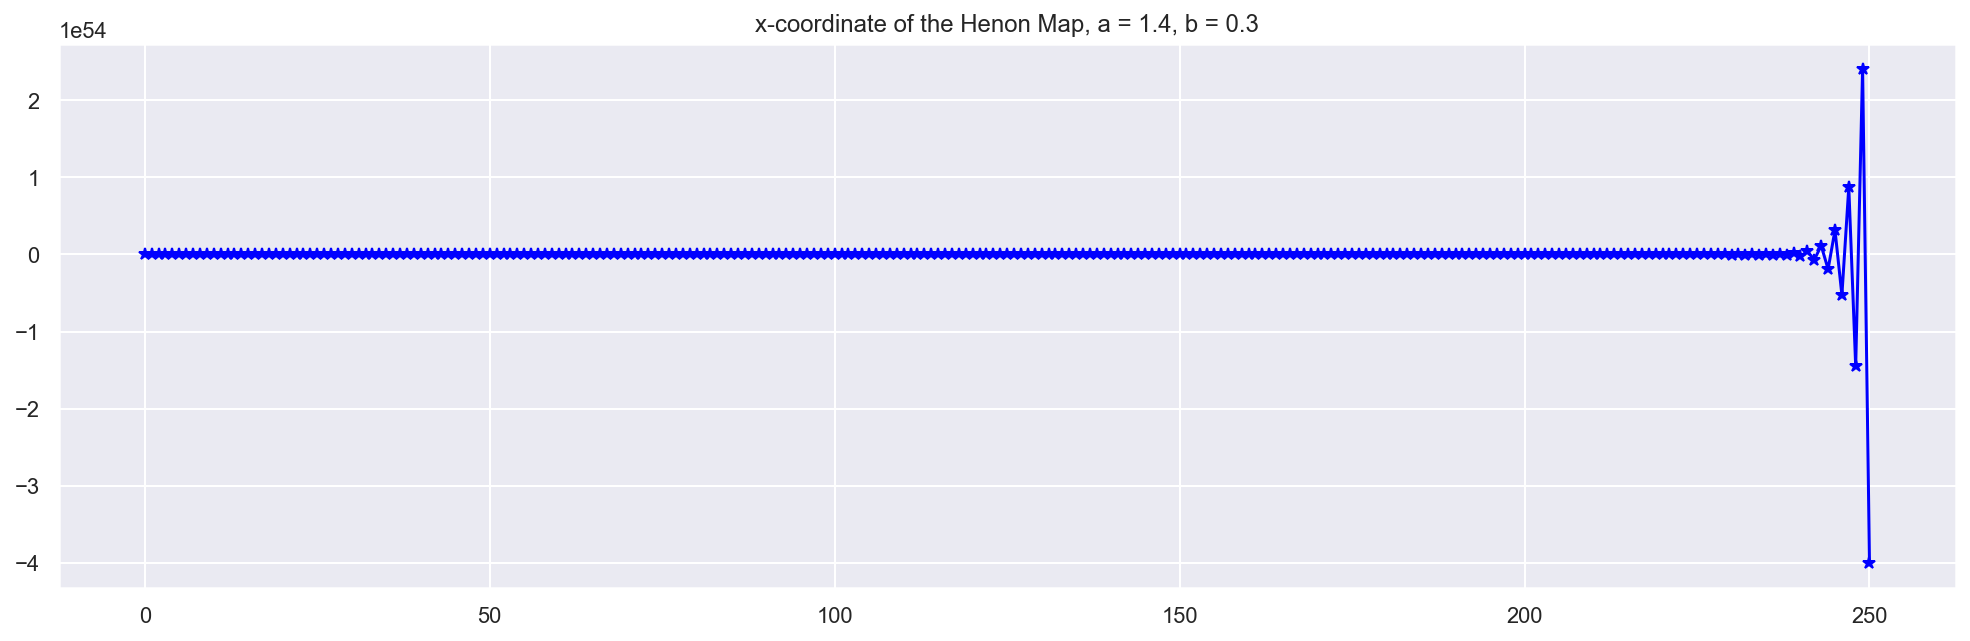

In [5]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(hen_map, "-*", color='blue', alpha=1);
ax.set_title(f"x-coordinate of the Henon Map, a = {a}, b = {b}",);

On observe bien un comportement chaotique: la série temporelle **explose** jusqu'à prendre des amplitudes supérieures à $10^{53}$.

#### 4.1.2 Attracteur de Henon modifié: processus de diffusion

Dans cette partie, on implémente et visualise des séries temporelles généres par la **version modifiée** et **stochastique** de **l'attracteur de Henon**, qui correspond à un **processus de diffusion**. Les paramètres sont à présent $(a, b) \in \mathbb{R}^2, \, \Delta t > 0$ et $\sigma^2 > 0$.  

Pour $(x_0, y_0, a_0)$ point initiaux, les équations sont données par:

\begin{align}
	\begin{cases}
		x_{n+1} = 1 - a_n \cdot x_n^2 + b \cdot y_n + \sigma W_n \cdot \sqrt{\Delta t} 		 \\
		y_{n+1} = x_n + \sigma W_n \cdot \sqrt{\Delta t}		 \\
		a_{n+1} = a_n + \Delta t		
	\end{cases}
\end{align}

où les $(W_n)_{n\geq0}$ sont des variables aléatoires **gaussiennes** centrées et réduites.

À présent, on calcule et conserve en mémoire les valeurs de $(x_n, \, y_n, \, a_n)_{n\geq0}$.

De plus, on peut noter via la mise à jour de la suite $(a_n)_{n\geq 0}$ que celle-ci joue un rôle similaire au **temps**, on pourra donc afficher l'évolution de $(x_n)_{n \geq 0}$ en fonction de $(a_n)_{n\geq 0}$

In [6]:
def diffusion_process(n_samples, b, sigma2, delta_t, x_0=0, y_0=0, a_0=0):
    """
    Get a time serie from the diffusion process equation given in the article
    Parameters:
      num_samples: int, number of points to draw
      b: float, parameter of the diffusion process equation
      sigma2: float, variance of the noise
      delta_t: float, time discretization step
      a_0: float, initial time like parameter
      x_0: float, initial x-coordinate
      y_0: float, initial y-coordinate
    Returns:
      diff_process: np.array, size n_samples+1 x 3, time serie drawn from diffusion process  equation
    """
    diff_process = np.concatenate((np.array([x_0, y_0, a_0])[None, :], np.zeros((n_samples-1, 3))), axis=0)
        
    for ii in range(n_samples-1):
        
        # draw noise
        w = np.random.randn()
        
        # compute current x-coordinate 
        diff_process[ii+1, 0] = 1 - diff_process[ii, 2] * diff_process[ii, 0]**2 + b * diff_process[ii, 1] + sigma2 * w * np.sqrt(delta_t)
        
        # compute current y-coordinate 
        diff_process[ii+1, 1] = diff_process[ii, 0] + sigma2 * w * np.sqrt(delta_t)
        
        # compute current parameter a
        diff_process[ii+1, 2] = diff_process[ii, 2] + delta_t
    
    return diff_process

Affichons alors la série temporelle $(x_n)_{n \in \{0,...N-1\}}$ pour $b = 0.3$, $\sigma^2=1$, $a_0 = 0$ et $\delta_t$ choisit de sorte que $(a_n)_{n \geq 0}$ évolue de $0$ à $1.4$. On fixe également $(x_0, y_0) = (1.5, 1.5)$.  
On éspère alors observer un **processus de diffusion** assez chaotique, comme sur la **figure 2** de l'article.

In [7]:
# compute diffusion process
n_samples = 1300
sigma2 = 1
b = .3
delta_t = 1.4 / n_samples # let a vary from 0 to 1.4
a_time = np.linspace(0, 1.4, n_samples)
x_0, y_0, a_0 = 1.4, 1.4, 0
diff_process = diffusion_process(n_samples, b, sigma2, delta_t, x_0=x_0, y_0=y_0, a_0=a_0)

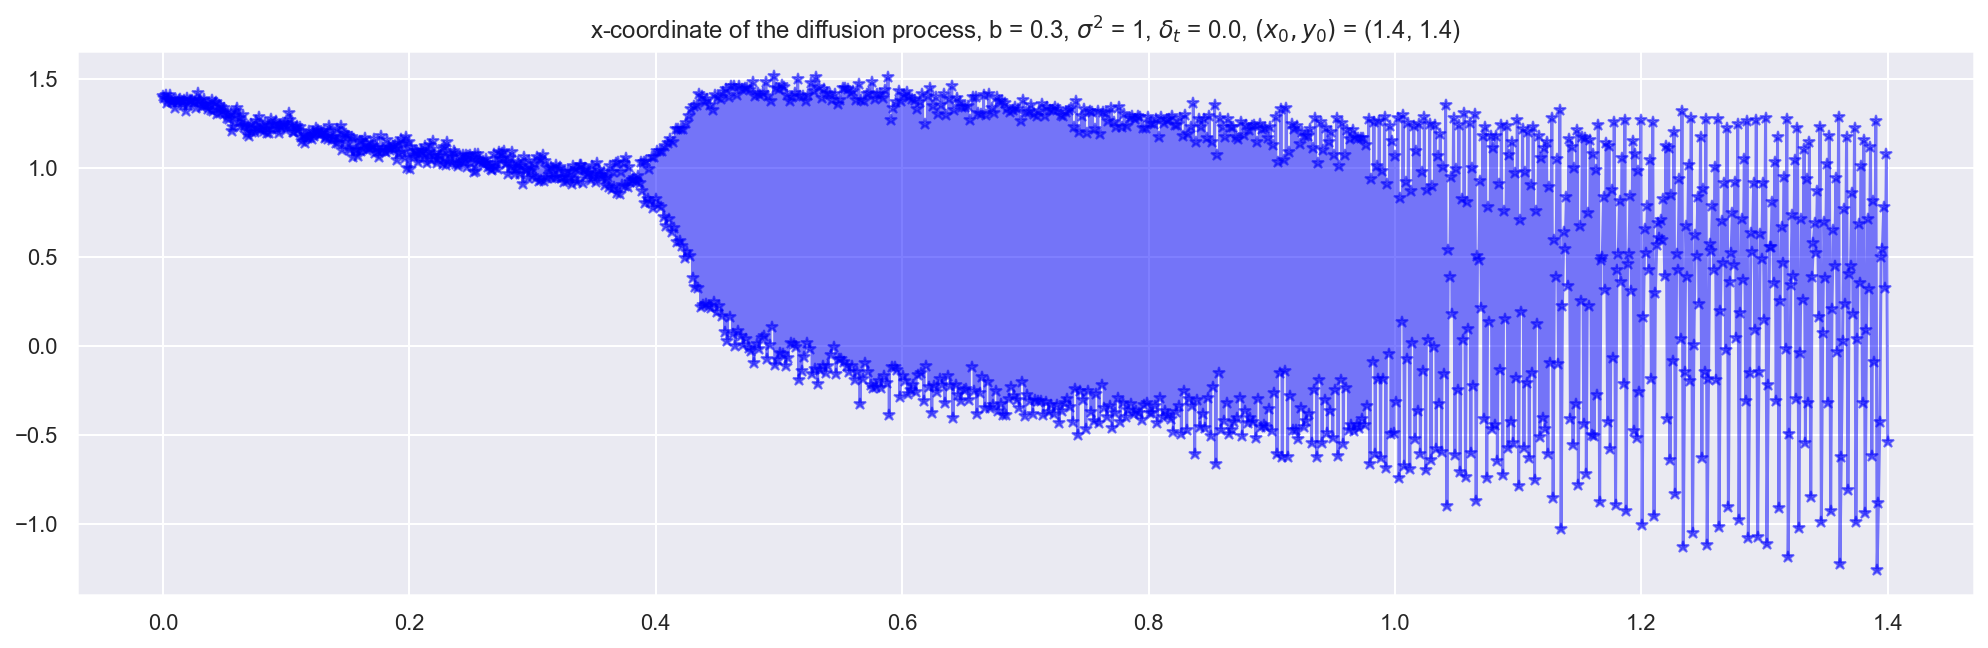

In [8]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(a_time, diff_process[:, 0], "-*", color='blue', alpha=.5);
ax.set_title(f"x-coordinate of the diffusion process, b = {b}, $\\sigma^2$ = {sigma2}, $\\delta_t$ = {round(delta_t, 2)}, $(x_0, y_0)$ = {(x_0, y_0)}");

On observe bien un comportement **extrêmement chaotique** dès lors que $a_n \geq 0.4$. On retrouve bien sensiblement le **même processus de diffusion** que sur la **figure 2** de l'article.

#### 4.1.3 Expérience numérique : TDA pour le processus de diffusion

On reproduit ici l'expérience de l'article visant à démontrer que lorsque l'on construit une **série multi-variée** de dimension $d=4$ à partir de 4 **processus de diffusions** avec des paramères $b$ différents sur chacune des dimensions, les persistences landscapes associés à cette série permettent bien de retrouver le comportement **chaotique** de la série. 

On construit donc une série $(x_n)_{n\geq 0}$ où $\forall n \in \mathbb{N}, \, x_n = (x_n^1, ..., x_n^4) \, \in \mathbb{R}^4$. Les paramètres $b$ pour les processus sur chacune des dimesnions son $b \in \{ 0.27, \, 0.28, \, 0.29, \, 0.3 \}$. Les paramètres $(x_0, y_0, a_0)$, $\sigma^2$ et $\delta_t$ sont choisit comme sur la figure ci-dessus et seront fixés pour tout la suite de cette section. Le nombre d'échantillon est lui fixé à $N = 1300$.

On fixe ensuite une taille de fenêtre $w = 50$ et on calcule la suite de nuage de points $\mathbb{R}^4$ comme définie précedemment. On calcule alors le diagrame de persistence et on en déduit les peristent landscapes lié à la peristent homology de dimesnion 1 de chacun de ces diagrammes, puis on calcule leur norme $L_1$ et leur norme $L_2$.

Comme cette section correspond à notre **première manipulation** des diagrammes de persistente et des persistent landscapes, celle-ci sera **assez détaillée**, afin d'avoir un meilleur appréhension des outils que l'on manipule.  
Les prochaines seront plus succintes et iront davantage à l'essentiel.

#### Construction de la séries temporelle multi-variée

On calcule chaque dimension $(x_n^1, ..., x_n^4)_{n \in \{0,...N-1\}}$ de la série temporelle $(x_n)_{n \in \{0,...N-1\}}$, où $N-1=1300$.

In [9]:
# compute 4 diffusion process
n_samples = 1300
sigma2 = 1
delta_t = 1.4 / n_samples # let a vary from 0 to 1.4
a_time = np.linspace(0, 1.4, n_samples)
b_list = [.27, .28, .29, .3]
x_diff_process = np.array([diffusion_process(n_samples, b_list[0], sigma2, delta_t, x_0=x_0, y_0=y_0, a_0=a_0)[:, 0],
                           diffusion_process(n_samples, b_list[1], sigma2, delta_t, x_0=x_0, y_0=y_0, a_0=a_0)[:, 0],
                           diffusion_process(n_samples, b_list[2], sigma2, delta_t, x_0=x_0, y_0=y_0, a_0=a_0)[:, 0],
                           diffusion_process(n_samples, b_list[3], sigma2, delta_t, x_0=x_0, y_0=y_0, a_0=a_0)[:, 0]]).T
print(f"Shape of the time serie : {x_diff_process.shape}.")

Shape of the time serie : (1300, 4).


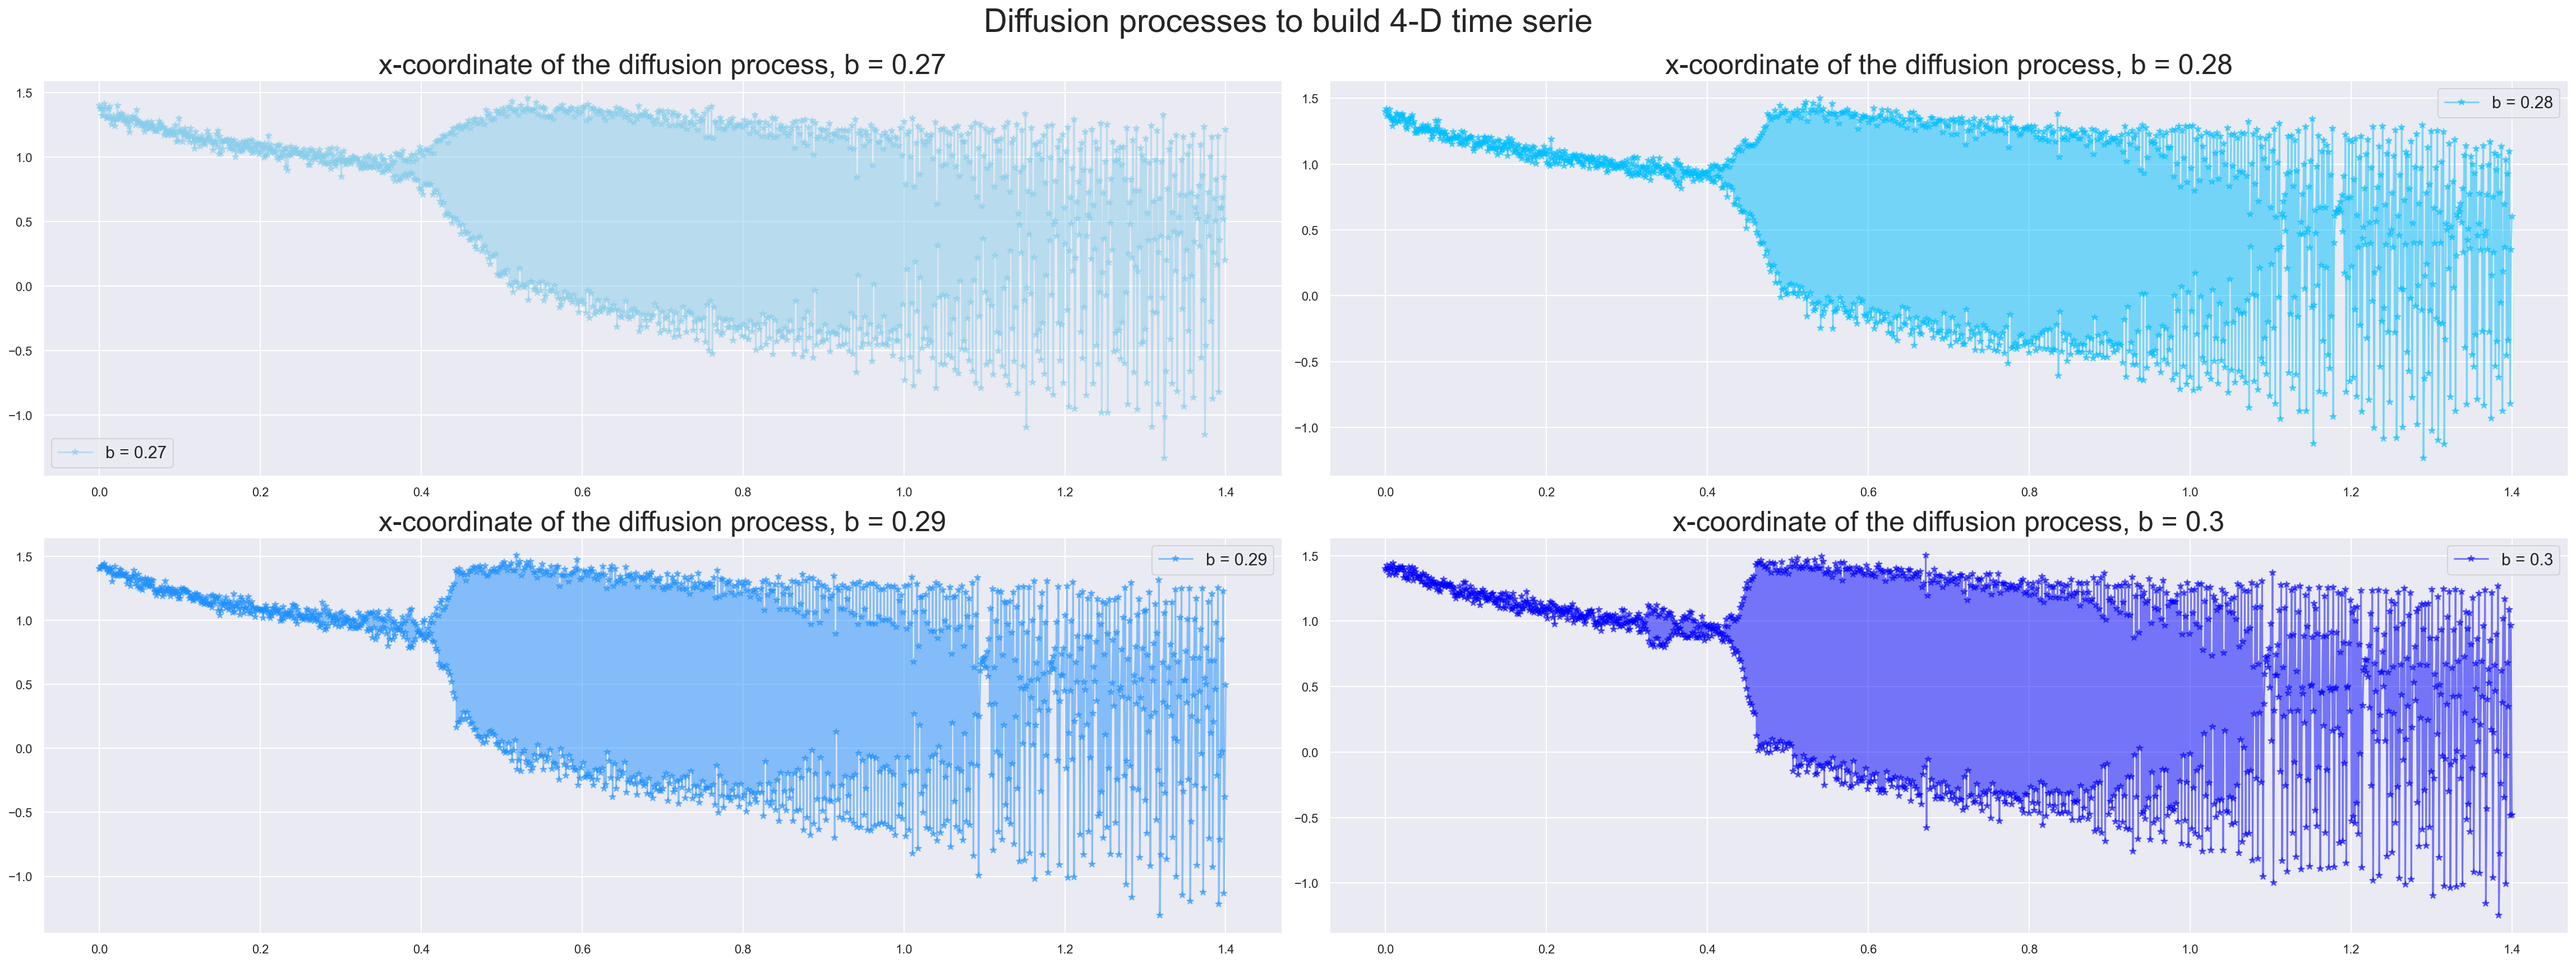

In [10]:
colors = ['skyblue', 'deepskyblue', 'dodgerblue', 'blue']
fig, ax = plt.subplots(2, 2, figsize=(16*2, 6*2))
ax = ax.ravel()
for ii in range(len(ax)):
    ax[ii].plot(a_time, x_diff_process[:, ii], "-*", color=colors[ii], label=f"b = {b_list[ii]}", alpha=.5);
    ax[ii].legend(fontsize=15)
    ax[ii].set_title(f"x-coordinate of the diffusion process, b = {b_list[ii]}",
                    fontsize=25);
fig.suptitle("Diffusion processes to build 4-D time serie", fontsize=29, y=.99)
fig.tight_layout();

La **série temporelle multi-variée** $(x_n)_{n \in \{0,...N-1\}}$ où $\forall n \in \mathbb{N}, \, x_n = (x_n^1, ..., x_n^4)$ est alors fomée des **4 séries temporelles** affichées sur les figures ci-dessus.

On peut noter que plus $b$ **augmente**, plus le **chaos émerge tôt** dans la série temporelle. Lorsque $b=0.27$, il n'émerge qu'en $a\approx 4.75$ alors que pour $b=0.3$, il émerge vers $a\approx 3$. Il est alors important de noter, pour la suite des expériences, que le chaos n'émèrge pas au même moment pour toutes les dimensions de la série temporelle $(x_n)_{n\geq 0}$.

#### Construction des nuages de points
On calcule chaque nuage de point $\{\hat{X}_1, ..., \hat{X}_m\}$. Pour cela, on applique une **fenêtre glissante** de taille $w=50$ et de **chevauchement** $o=w-1=49$ au signal, donc $m=N-w+1=1251$.  
Le **choix** de ces paramètres est effectué en **accord** avec l'**article**.

In [11]:
scaler = StandardScaler()
scaler.fit(x_diff_process)
x_diff_process = scaler.transform(x_diff_process)

NameError: name 'StandardScaler' is not defined

In [ ]:
# compute point clouds
w = 50
pt_clouds = compute_pt_clouds(time_serie=x_diff_process, window_size=w)
print(f"Shape of the point clouds matrix : {pt_clouds.shape}.")

#### Construction des diagrammes de persistence
On calcule le diagramme de persistence $\mathrm{dgm}(\hat{X}_i)$ associé à l'homologie de dimension 0 et 1 de chaque nuage de point $\hat{X}_i$.

In [ ]:
# compute persistence diagrams
diag_list = compute_diagrams(pt_clouds)

On peut alors **afficher quelques diagrammes de persistence** parmi les diagrammes de persistence de tous les nuages de point.

In [ ]:
# select some random indeces
idxs = np.random.choice(len(diag_list), size=3)

# plot corresponding diagrams
fig, ax = plt.subplots(1, 3, figsize=(7*3, 6))
ax = ax.ravel()
gd.plot_persistence_diagram(diag_list[idxs[0]], axes=ax[0], legend=True, alpha=.9);
gd.plot_persistence_diagram(diag_list[idxs[1]], axes=ax[1], legend=True, alpha=.9);
gd.plot_persistence_diagram(diag_list[idxs[2]], axes=ax[2], legend=True, alpha=.9);
ax[0].set_title(f"Persistence diagram {idxs[0]}", fontsize=15)
ax[1].set_title(f"Persistence diagram {idxs[1]}", fontsize=15)
ax[2].set_title(f"Persistence diagram {idxs[2]}", fontsize=15);

On observe donc des diagrammes de persistence **assez différents**, ce qui témoigne d'une **topologie différente** dans les différents **nuages de points**. Les featurs topologiques correspondant à l'homologie de dimension 0 sont en $\color{red}{\text{rouge}}$ alors que les featurs topologiques correspondant à l'homologie de dimension 1 sont en $\color{blue}{\text{bleu}}$. **Analysons** brièvement ces homologies.

Ces quelques **commentaires** ne sont **pas essentiels** à la lecture et la compréhension du notebook, ils donnent **quelques intuitions** sur les **diagrammes de persistence**.

**Homologie de dimension 0:**  

Même si nous n'allons pas utiliser cette homologie pour la suite des calculs car c'est l'homologie de dimension 1 qui sera utilisée, on peut tout de même l'analyser afin d'avoir une meilleur intuition de la topologie des nuages de points. La persistent homology homologie de dimension 0 encode la naissance et la mort de **composantes connexes** dans le complexe simpliciel. 

On peut noter que toutes les composantes connexes naissent en 0, ce qui signifie que l'on commence par ajouter tous les sommets dans le somplexes simpliciel avant de construire la filtration. Puis, les composantes meurent petites à petit jusqu'à ce que l'on conserve une et unique compossante connexe, le nuage de point entier. La mort des composantes connexes est plus ou moins rapide selon les nuages de points, ce qui signifie que les points sont plus ou moins dispersé dans $\mathbb{R}^4$ selon les nuages de points. 

Enfin, on peut préciser que comme le point  $(0, \infty)$ appartient à tous les diagrammes, le perstistence landscape numéro 1 associé à l'homologie de dimension 0 de tous les diagrammes est une droite partant de l'origine.

**Homologie de dimension 1:**

C'est avec cette homologie que l'on va calculer les persistence landscapes et donc tenter de retrouver le comportement chaotique de la série temporelle. La persistent homology homologie de dimension 1 encode la naissance et la mort de **cycles** dans le complexe simpliciel.  

On observe que les diagrammes sont assez différents. Pour certains, on observe beaucoup de points proches de l'origine et de la diagonale, ce qui correspond à des cycles qui naissent au début de la construction de la filtration et meurent rapidement. Pour d'autres, les points sont plus haut dans le diagramme et plus ou moins proches de la diagonale. 

Notons que plus un point est **loin de la diagonale**, **plus** il "**persiste**" et la feature topologique associée est donc considéré comme une **feature topologique importante**. Ces points induisent des triangles de plus grande aire lorsque l'on retourne le digramme et que l'on se place dans le système de coordonnées $\left( (d+b)/2,\, (d-b)/2 \right)$ afin de construire les persistence landscapes. Ils induisent donc des persistence landscapes de grande norme $L_p$. 

À l'inverse, plus un point est **proche de la diagonale**, **moins** il "**persiste**" et la feature topologique associée est donc considéré comme une **feature topologique** est **moins importante**. On appelle comunnément ce type de points du "**bruit topologique**". Par le même raisonnement que précedemment, ils induisent des persistence landscapes de faibles normes $L_p$.

#### Construction des persistence landscapes 

On calcule les 5 premiers persistences landscapes $(\lambda_k(\hat{X}_i, \cdot))_{k\in\{1, ..., 5\}}$ associé à l'homologie de dimension 1 de chaque nuage de point $\hat{X}_i$.

In [ ]:
# compute persistent landscapes
p_dim = 1
x_min, x_max = 0, 7.5 # use large regular grid to be sure to contain the support
nb_nodes = 500
nb_ld = 5
landscapes = compute_landscapes(diag_list, p_dim, x_min, x_max, nb_nodes, nb_ld)
print(f"Shape of the persistence landscapes matrix : {landscapes.shape}.")

On peut alors **afficher quelques persistence landscapes** parmi les **persistence landscapes** de tous les nuages de point.

In [ ]:
# plot corresponding landscapes
fig, ax = plt.subplots(1, 3, figsize=(9*3, 6))
ax = ax.ravel()
for ii in range(len(idxs)):
    plot_landscape(landscapes[idxs[ii]], ax=ax[ii], idx=idxs[ii], pad=5)

On observe donc des persistence landscapes **assez différents**, surtout en terme d'amplitude, ce qui témoigne une nouvelle fois d'une **topologie différente** dans les différents **nuages de points**. **Analysons** brièvement ces persistent landscapes.

Ces quelques **commentaires** ne sont **pas essentiels** à la lecture et la compréhension du notebook, ils donnent **quelques intuitions** sur les **persistent landscapes**.

On observe tout d'abord que certains persistence landscapes ont des **amplitude très faibles**, ne dépassant pas $0.01$, ils auront donc de faibles normes $L_p$. Ils correspondent à des diagrammes de persistence ayant des points liés à l'homologie de dimension 1 très proches de la diagonale, i.e du **bruit topologique**. 

Pour d'autres, on observe des **amplitudes plus élevées** allant jusqu'à $0.2$,  ce qui tendra à donner des normes $L_p$ plus grande. Ils correspondent à des diagrammes de persistence ayant des points liés à l'homologie de dimension 1 plus loins de la diagonale, i.e des **features topologiques "persistente"** et non du bruit topologique.

On voit donc que la **norme $L_p$** de **ces persistence landscapes** permet de détecter **l'importance** des **features topologiques** liés à l'**homologie de dimension 1**.

#### Calcul de norme des persistence landscapes 

On calcule les normes $L_p$ avec $p=1,2$ des persistent landscapes associé à chaque nuage de point, ce qui nous donne alors deux séries temporelles à $m$ échantillons:

\begin{align}
	\begin{cases}
		\lambda^1 = (\|\lambda(\hat{X}_1, \cdot)\|_1, ..., \|\lambda(\hat{X}_m, \cdot)\|_1) 		 \\
		\lambda^2 = (\|\lambda(\hat{X}_1, \cdot)\|_2, ..., \|\lambda(\hat{X}_m, \cdot)\|_2) 		
	\end{cases}
\end{align}

In [ ]:
# get norm L1 and L2 norms of the landscapes associated to each point clouds
X_norms = compute_norms(landscapes)
print(f"Range of values of X_norm along each dimension before pre-processing: {(X_norms.min(axis=0), X_norms.max(axis=0))}.")

# normalize signals 
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_norms)
X_norms = scaler.transform(X_norms)
print(f"Range of values of X_norm along each dimension after pre-processing: {(X_norms.min(axis=0), X_norms.max(axis=0))}.")

#### Résultats 

In [ ]:
fig, ax = plt.subplots()
ax.plot(X_norms[:, 0], label='$L_1$ norm', c='blue', alpha=.8)
ax.plot(X_norms[:, 1], label='$L_2$ norm', c='red', alpha=.8)
ax.legend()
ax.set_xlabel('point cloud number')
ax.set_ylabel('$L_p$ norms')
ax.set_title('Persistent landscapes $L_p$ norms');

On retrouve bien le comportement éspéré, c'est à dire une **phase stable** et une **phase chaotique**.

#### Pourquoi n'avons nous pas exactmement la même figure que celle présentée dans l'article ?

Il est intéressant de noter que cette figure n'est **pas strictement identique** à la **figure 4** de l'article. Expliquons alors quelques **éléments** qui pourrait être **à l'origine** de **cette différence**.


#### Bilan

La conclusion de cette expérience numérique est que les **normes $L_p$** des **persistence landscapes** ont la capacité de détecter les **transitions** entre les **régimes réguliers** et **chaotiques**. 

Le **passage** d'une **dynamique régulière** à une **dynamique chaotique** détermine des **changements significatifs** dans la **topologie** des **nuages de points** costruits à partr de la série temporelle, qui sont détectés très clairement par les séries temporelles constituées des normes $L_p$ des persistent landscapes.

In [ ]:
from gudhi.representations.vector_methods import Landscape

# boolean to avoid useless running
test_with_gudhi = True
if test_with_gudhi==True:
    
    # map the diagrams to the format required by the class Landscape
    f = lambda diag: list(map(lambda x: [x[0], x[1][0], x[1][1]], diag))
    diags = list(map(f, diag_list))
    g = lambda x: np.array(x)[np.array(x)[:, 0]==1]
    diags = list(map(g, diags))
    
    # compute persistent landscapes
    ld = Landscape(num_landscapes=5, resolution=500, sample_range=[0, 7.5])
    ld.fit(diags)
    L = ld.transform(diags)
    L = L.reshape(len(diag_list), 5, 500)
    
    # compute their norms
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_norms)
    X_norms = scaler.transform(X_norms)
    
    # plot them
    fig, ax = plt.subplots()
    ax.plot(X_norms[:, 0], label='$L_1$ norm', c='blue', alpha=.8)
    ax.plot(X_norms[:, 1], label='$L_2$ norm', c='red', alpha=.8)
    ax.legend()
    ax.set_xlabel('point cloud number')
    ax.set_ylabel('$L_p$ norms')
    ax.set_title('Persistent landscapes $L_p$ norms');

### 4.2. Bruit blanc avec variance croissante

#### 4.2.1. Motivations financières

En finance quantitative, on fait souvent l'hypothèse que les **prix des actions** suivent un **mouvement brownien géométrique** avec des **coefficients** de **drift** et de **diffusion constants**. Ce modèle conduit à des rendements boursiers normalement distribués.  

On rappelle alors que ces derniers (aussi appelés log-rendement) sont définis comme la **différence** du **logarithme des prix** séparés d'un **décalage temporel donné**, i.e pour une action (ou indice) $a^0$ dont le cours est donné par $a^0_t$ à l'instant $t$, et un décalage temporel $\Delta_t$ donné, ce rendement boursier est $R^0_t = \log(a^0_{t+\Delta_t}) - \log(a^0_t)$.

Lors de l'étude de **séries financière réelles**, nous nous intéresserons à **4 actions** $(a^i)_{i\in \{1,...,4\}}$, pour lesquelles nous formerons les **4 rendements boursiers $(R^{i})_{i\in \{1,...4\}}$**. On obtiendra alors une série temporelle multi-variée de dimension 4, où chaque dimension est genérée par un processus gaussien, à laquelle nous appliquerons notre méthode d'analyse topologique. 

Ainsi, interessons nous au **cas le plus simple** de **série temporelle multi-variée** de dimension 4 où **chaque dimension** est génére à partir d'un **processus gaussien** : générons chaque coordonnée par un **bruit blanc** de variance $\sigma^2$. Notamment, le but de cette expérience est d'étudier **l'influence de $\sigma^2$** sur les normes $L_1$ et $L_2$ des persistent landscapes, et donc sur la topologie, des nuages de points générés à partir des cette série temporelle.

#### 4.2.2. Expérience numérique : TDA pour le bruit blanc avec variance croissante

On reproduit ici l'expérience de l'article visant à démontrer que lorsque l'on construit une **série multi-variée** de dimension $d=4$, $(x_n)_{n\in\{1,...,N\}}$, à partir de 4 **bruits blancs**, et que l'on considère directement celle-ci comme un nuage de $N$ points dans $\mathbb{R}^4$, alors la **norme $L_1$** et $L_2$ des **persistent landscapes croît linéairement avec $\sigma^2$**. Le résultat pourrait se généraliser à n'importe quel nombre de dimension $d$, mais comme notre étude sur des séries financières réeles se basera sur des séries de dimension 4, on choisit ici $d=4$.

##### Pourquoi ne fenêtrons-nous pas le signal ici ? 

Ici, l'idée n'est pas de générer une suite de nuage de points à partir de la série temporelle en la fenêtrant, mais d'**étudier directement** la topologie de la série temporelle **comme** si c'était elle même une **fenêtre d'une série financière réelle**. 

C'est pour cette raison que l'on génère, comme dans l'article, une **série temporelle de taille $N=100$**, ce qui est du même ordre de grandeur que les tailles de fenêtre que l'on utilisera plus tard pour les séries financières réelles. 

##### Processus de génération des données 

On construit donc une série $(x_n)_{n\in\{1,...,N\}}$ où $\forall n \in \mathbb{N}, \, x_n = (x_n^1, ..., x_n^4) \, \in \mathbb{R}^4$, générée de la sorte :

- fixer $\sigma > 0$,

- générer $(\delta_i)_{i \in \{1, .., 4\}} \sim_\text{i.i.d} \, U[-0.1, 0.1]$,

- pour tout $i \in \{1,...,4\}$, générer $(x_n^i)_{n\in\{1,...,N\}} \sim \mathcal{N}(0, (\sigma+\delta_i)^2I_N)$.

On étudie alors les propriétées topologiques de $X = \{x_1, ..., x_N\} \subset \mathbb{R}^4$.

##### Approximation par Monte-Carlo 

Notons alors $\mathbb{P}_X$ la **loi** de $X$, nuage de point généré selon cette méthode. 

Pour $\sigma^2$ variant de 1 à 100, on va alors approximer par **Monte-Carlo**, $\mathbb{E}_{X \sim \mathbb{P}_X}\left[\|\lambda(X, \cdot)\|_p \right]$ pour $p \in \{1,2\}$. Précisément, on va générer $N_{MC}$ nuages de points $(X_i)_{n\in\{1,...,N_{MC}\}}$ $\text{i.i.d}$ selon cette méthode et approximer :
$$
\mathbb{E}_{X \sim \mathbb{P}_X}\left[\|\lambda(X, \cdot)\|_p \right] \approx \frac{1}{N_{MC}} \sum_{i=1}^{N_{MC}} \|\lambda(X_i, \cdot)\|_p
$$

On éspère alors que cette **quantité croisse linéairement** lorsque $\sigma^2$ croît de **1 à 100**.

In [ ]:
def generate_dataset_gauss(sigma, n_samples=100, dim=4):
    """
    Generate datasets: a point cloud of n_samples samples in R^dim 
    Along each dimension, data is generated from a withe noise with std sigma + delta where delta ~ unif[-.1, .1]
    """
    X = np.zeros((n_samples, dim))
    deltas = .2 * np.random.rand(dim) - .1
    variances = sigma + deltas
    for ii in range(dim):
        X[:, ii] = np.random.multivariate_normal(mean=np.zeros(n_samples), cov=variances[ii]*np.eye(n_samples))
    return X

def MC_simulation(sigma, n_MC=20, n_samples=100, dim=4, law='gaussian'):
    """
    Compute Monte-Carlo approximation of the expactation of the L1 and L2 norms of the persistence landscapes  
    of point cloud genrated using the generation process described above. 
    """
    sample_norms = np.zeros((n_MC, 2))
    
    # loop over the Monte-Carlo iterations
    for ii in tqdm(range(n_MC)):
        
        # generate dataset
        if law=='gaussian':
            X = generate_dataset_gauss(sigma=sigma, n_samples=100, dim=4)
        
        # compute persistence diagram
        diag = compute_diagram(X)
        
        # compute persistence landscapes
        landscapes = landscape_approx(diag, x_min=0, x_max=50)  # large limits to be sure to include the support
         
        # compute and store persistence landscapes norms
        sample_norms[ii] = compute_norms(landscapes[None, :]).squeeze()  

    return sample_norms.mean(axis=0)

#### Un exemple : $\sigma^2=10$

Avant d'effectuer l'expérience détaillée ci-dessus, examinons la série temporelle et la topologie obtenue lorsque l'on fixe $\sigma^2=1$.

In [ ]:
# generate a 4 time series according to the generation process detailled before
sigma = 1
X = generate_dataset_gauss(sigma, n_samples=100, dim=4)
print(f"Shape of the point cloud: {X.shape}.")

In [ ]:
# plot it
fig, ax = plt.subplots()
ax.plot(X);
ax.set_title(f"Time serie generated from 4 gaussian noises, $\\sigma=${sigma}");

On observe donc, comme espéré, un comportement **purement chaotique** typique d'un bruit blanc gaussien.

In [ ]:
# compute persistence diagram and persistence landscapes
diag = compute_diagram(X)
land = landscape_approx(diag) 

# plot it 
fig, ax = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 2]}, figsize=(22, 6))
gd.plot_persistence_diagram(diag, axes=ax[0]);
ax[0].set_title(f"Persistent diagram of white noise $\\sigma=${sigma}");
plot_landscape(land, ax[1], title=False)
ax[1].set_title(f"Persistent landscape of white noise $\\sigma=${sigma}");

On voit donc que l'on a une **topologie assez riche** avec de **nombreux points** qui ne sont **pas du bruit topologique**, à la fois pour l'homologie de dimension 0 et de dimension 1.  
Ceci se traduit alors par un **persistent lanscape** (associé à l'homologie de dimension 1 toujours) à **support assez grand** et d'**amplitudes assez hautes**, synonyme de normes $L_1$ et $L_2$ de pestitent landscapes élevées.

#### L'expérience

On effectue ici l'**expérience détaillée précédemment**.  
Pour cela, on choisit d'approximer les espérances des persistent landscapes pour $p\in \{1,2\}$ avec $N_{MC} = 200$ **nuages de points** générés pour chaque valeur de $\sigma^2$.

In [ ]:
sigma2_arr = np.linspace(1, 100, 11)
MC_norms_arr = np.zeros((len(sigma2_arr), 2))
for ii in range(len(sigma2_arr)):
    print(f"Step {ii+1}, sigma = {round(sigma2_arr[ii], 3)}: in progress...")
    time.sleep(.5) # avoid printing trouble
    MC_norms_arr[ii] = MC_simulation(sigma=np.sqrt(sigma2_arr[ii]), n_MC=200)
    time.sleep(.5)
    print(f"Step {ii+1}, sigma = {round(sigma2_arr[ii], 3)}: done!\n")

In [ ]:
fig, ax = plt.subplots()
colors = ['red', 'blue']
for ii in range(MC_norms_arr.shape[1]):
    ax.plot(np.sqrt(sigma2_arr), MC_norms_arr[:, ii], c=colors[ii], label=f'$L_{ii+1}$ norm')
ax.legend()
ax.set_title("Monte Carlo approximation of white noise persistent landscapes norm with increasing variance")
ax.set_xlabel("variance")
ax.set_ylabel("Monte Carlo approximation");

On observe donc bien la **croissance linéaire éspérée**. On retrouve alors la **figure 5** de l'article.

#### Que signifie topologiquement cette croissance linéaire ?

L'intuition derrière cette croissance linéaire provient du fait que lorsque l'on **multiplie l'écart type** du **bruit blanc gaussien** $\sigma$ par un facteur $F$, on **multiplie** par $F$ l'**amplitude des variations** du bruit blanc gaussien, donc on multiplie par $F$ les **distances entre les points** du nuage de points. Ainsi, en exploitant la définition du complexe de **Vietoris-Rips**, que l'on utilise ici pour construire le diagramme de persistence, tout **point** $\alpha = (b_\alpha, d_\alpha)$ du diagramme de persistence devient $\alpha' = (F\cdot b_\alpha, F\cdot d_\alpha)$.

Par conséquent, la **base** et la **hauteur** du **triangle** associé à chaque point du diagramme de persistence sont **multipliées** par $F$, leur **aire** est donc multipliée par $F^2$. Ainsi, par homogénéinté des normes $L_p$, lorsque l'on multiplie l'écart type par un facteur $F$, on multiplie la norme des persistent landscapes par un facteur $F^2$. Or, multiplier l'écart type par un facteur $F$ revient à multiplier la variance par $F^2$ donc on a bien la **linéarité** voulue **par rapport** à la **variance**.

#### Bilan

Outre la linéarité de la croissance de la norme des persistent landscapes avec la variance, ce qu'il est important de noter c'est que : lorsque qu'une fenêtre (ici de taille $N=100$) d'une série temporelle génére à partir d'un bruit blanc gaussien, plus la variance de ce bruit blanc est grande, plus la norme du persistent landscape du nuage de point associé est grande. Ainsi une **volatilité élevée** se traduit par des **persistent landscapes** de **norme élevée**, ce qui donne une nouvelle fois de la pertinence à notre approche.

### 4.3 Bruit blanc avec une variance distribuée selon une loi inverse Gamma

## 5. Expériences sur données financières

Dans cette section, on va appliquer notre méthode d'analyse topologique sur des séries financières réelles. Pour cela, nous allons utiliser quatre indices boursiers majeurs américains : 
- **S&P 500**, 
- **DJIA**,
- **NASDAQ**,
- **Russel 2000**. 

### 5.1. Téléchargement des données

Ces données sont téléchargées à partir de la libraire ``yfinance``, contenant la base de données de **Yahoo Finance**. On s'intéresse aux **trading days entre** le **'1992-01-01'** et le dernier **trading day** (la base de donnée de Yahoo Finance est actualisée en temps réel chaque jour). 

Notons que les auteurs de l'article se sont intéressés aux trading days entre le 23 décembre 1987 et 08 décembre 2016 et se sont principalement intéréssé à la détection des **crashs boursiers** de **2000** et **2008**. Nous n'avons pas réussi à nous procurer, pour l'indice **DIJA**, des données remontant jusqu'en 1987. Ceci assez étonnant, car il est précisé dans l'article que les auteurs se sont, eux aussi, procurer les données à partir de **Yahoo Finance**. En revanche, ce n'est pas un problème fondamental, puisque l'on conserve les deux crashs boursiers que l'on souhaite détecter. De plus, nous allons pouvoir tester notre méthode sur un **nouveau crash boursier**, le crash lié à l'épidémie du **covid** ! 

Les dates clefs liées à ces trois crashs sont:

- crash de **2000** (Dot-com bubble ou technology crash) : **10 mars 2000**,

- crash de **2008** (Bankruptcy of Lehman Brothers après la cris des subprimes) : **15 sepetembre 2008**,

- crash de **2020** (Covid) : **20 février 2020**.

Pour les crashs de **2000** et de **2020**, on peut voir les **dates** ci-dessus comme les dates de **début de crash**.  
En revanche, pour le crash de **2008**, c'est plutôt une **date emblématique**, la "Bankruptcy of Lehman Brothers", après la crise des subprimes. Avant cette date (sur quelques mois), nous devrions déjà observer une décroissance des indices boursiers.

In [ ]:
# technonolgy crash
date1 = '2000-03-10'
print(f"Technology crash date: {'2000-03-10'}.")
# lehman bankruptcy
date2 = '2008-09-15'
print(f"Lehman bankruptcy date: {'2008-09-15'}.")
# covid crash
date3 = '2020-02-20'
print(f"Covid crash date: {'2020-02-20'}.")

#### S&P 500

In [ ]:
# load data
SP500 = yf.Ticker("^GSPC")
sp500_df = SP500.history(period="max")
sp500_df = sp500_df.drop(sp500_df[(sp500_df.index < '1992-01-02') | (sp500_df.index > '2021-03-20')].index)
print(f"We have kept {len(sp500_df)} trading days.")
sp500_df.head(3)

In [ ]:
# plot close price
price_sp500 = sp500_df['Close']
price_sp500.plot()
plt.vlines(x=date1, ymin=price_sp500.min()-20, ymax=price_sp500.max()+20, linestyle='--', color='green', label='Technology crash')
plt.vlines(x=date2, ymin=price_sp500.min()-20, ymax=price_sp500.max()+20, linestyle='--', color='red', label='Lehman bankruptcy')
plt.vlines(x=date3, ymin=price_sp500.min()-20, ymax=price_sp500.max()+20, linestyle='--', color='orange', label='Covid crash')
plt.legend()
plt.title('Close Price S&P 500')
plt.show()

#### NASDAQ

In [ ]:
# load data
nasdaq = yf.Ticker('^IXIC')
nasdaq_df = NASDAQ.history(period="max")
nasdaq_df = nasdaq_df.drop(nasdaq_df[(nasdaq_df.index < '1992-01-02') | (nasdaq_df.index > '2021-03-20')].index)
print(f"We have kept {len(nasdaq_df)} trading days.")
nasdaq_df.head(3)

In [ ]:
# plot close price
price_nasdaq = nasdaq_df['Close']
price_nasdaq.plot()
plt.vlines(x=date1, ymin=price_nasdaq.min()-20, ymax=price_nasdaq.max()+20, linestyle='--', color='green', label='Technology crash')
plt.vlines(x=date2, ymin=price_nasdaq.min()-20, ymax=price_nasdaq.max()+20, linestyle='--', color='red', label='Lehman bankruptcy')
plt.vlines(x=date3, ymin=price_nasdaq.min()-20, ymax=price_nasdaq.max()+20, linestyle='--', color='orange', label='Covid crash')
plt.legend()
plt.title('Close Price NASDAQ')
plt.show()

#### Russell 2000

In [ ]:
# load data
russell = yf.Ticker('^RUT')
russell_df = russell.history(period="max")
russell_df = russell_df.drop(russell_df[(russell_df.index < '1992-01-02') | (russell_df.index > '2021-03-20')].index)
print(f"We have kept {len(russell_df)} trading days.")
russell_df.head(3)

In [ ]:
# plot close price
price_russell = russell_df['Close']
price_russell.plot()
plt.vlines(x=date1, ymin=price_russell.min()-20, ymax=price_russell.max()+20, linestyle='--', color='green', label='Technology crash')
plt.vlines(x=date2, ymin=price_russell.min()-20, ymax=price_russell.max()+20, linestyle='--', color='red', label='Lehman bankruptcy')
plt.vlines(x=date3, ymin=price_russell.min()-20, ymax=price_russell.max()+20, linestyle='--', color='orange', label='Covid crash')
plt.legend()
plt.title('Close Price Russell 200')
plt.show()

#### DIJA

In [ ]:
# load data
DJIA = yf.Ticker("^DJI")
dija_df = DJIA.history(period="max")
dija_df = dija_df.drop(dija_df[(dija_df.index < '1992-01-02') | (dija_df.index > '2021-03-20')].index)
print(f"We have kept {len(DJIA_df)} trading days.")
dija_df.head(3)

In [ ]:
# plot close price
price_dija = dija_df['Close']
price_dija.plot()
plt.vlines(x=date1, ymin=price_dija.min()-20, ymax=price_dija.max()+20, linestyle='--', color='green', label='Technology crash')
plt.vlines(x=date2, ymin=price_dija.min()-20, ymax=price_dija.max()+20, linestyle='--', color='red', label='Lehman bankruptcy')
plt.vlines(x=date3, ymin=price_dija.min()-20, ymax=price_dija.max()+20, linestyle='--', color='orange', label='Covid crash')
plt.legend()
plt.title('Close Price DIJA')
plt.show()

### 5.2 Log-rendement 

Comme on l'a précisé en section 4.2, nous allons travailler avec les **log-rendement**. On rappelle pour une action (ou indice) $a^0$ dont le cours est donné par $a^0_t$ à l'instant $t$, et un décalage temporel $\Delta_t$ donné, ce log-rendement est $R^0_t = \log(a^0_{t+\Delta_t}) - \log(a^0_t)$.

Ici, comme on manipule quatre indices boursiers $(a_n^1, ...,a_n^4)_{n\in \{0,...,N-1\}}$, on forme les quatre log-rendements $(R_n^1,...,R_n^4)_{n\in \{0,...,N-1\}}$, ce qui va constituer notre série temporelle multi-variée de dimension 4. On prend ici comme décalage temporel $\Delta_t=$ 1 trading day, puisque notre série temporelle est échantillonnée tous les trading days.

Notons que cette transformation peut tendre à **rendre le signal plus stationnaire**, car on lui applique un **opérateur de différenciation**. Cela rappelle les modèles ARIMA, où la série temporelle est dérivée éventuellement plusieurs fois avant d'apprendre le modèle auto-régressif.  
**Nuançons** toutefois notre propos, il ne semble pas que l'enjeu soit ici de rendre la série stationnaire, car cette transformation est appliqué puisque ces quantités sont supposées normalement distribuées, comme on fait l'hypothèse que les **prix des actions** suivent un **mouvement brownien géométrique** avec des **coefficients** de **drift** et de **diffusion constants**. De plus, nous **n'appliquons pas** ici de **modèle statitsique nécessitant** la **stationnarité** de la série temporelle.

In [ ]:
# merge 4 times series in a unique dataframe 
df_close = pd.concat([price_sp500, price_nasdaq, price_russell, price_dija], axis=1)
df_close.columns = ['SP500','NASDAQ','Russell2000','DJIA']
df_close.head(3)

In [ ]:
def log_return(df_close):
    """
    Get the log-return for each time serie of the adjsted close prices dataframe.
    Parameters:
      df_close: pd.DataFrame of 4 columns, each column is the adjsted close price of a index
    Returns:
      df_log: pd.DataFrame of 4 columns, each column is the log-return of a index
    """
    df_log = pd.DataFrame(index=df_close.index[1:], columns=[col+'_logr' for col in df_close.columns])
    for col in df_close.columns:
        df_log[col+'_logr'] = np.log([df_close[col][ii]/df_close[col][ii-1] for ii in range(1, len(df_close))])
    return df_log

In [ ]:
# get 4 log returns dataframe
df_log = log_return(df_close)
df_log.head(3)

In [ ]:
# plot log-return
fig, ax = plt.subplots(2, 2, figsize=(12*2, 5*2))
ax = ax.ravel()
ii = 0
for col in df_log.columns:
    df_log[col].plot(ax=ax[ii])
    ax[ii].vlines(x=date1, ymin=df_log[col].min(), ymax=df_log[col].max(), linestyle='--', color='green', label='Technology crash', zorder=1, linewidths=2)
    ax[ii].vlines(x=date2, ymin=df_log[col].min(), ymax=df_log[col].max(), linestyle='--', color='red', label='Lehman bankruptcy', linewidths=2)
    ax[ii].vlines(x=date3, ymin=df_log[col].min(), ymax=df_log[col].max(), linestyle='--', color='orange', label='Covid crash', linewidths=2)
    ax[ii].legend()
    ax[ii].set_title(f'Log-return {col[:-5]}')
    ii += 1
plt.tight_layout()
plt.show()

On peut noter, effectivement, que les séries des log-rendements est **sensiblement plus stationnaire** que les séries des indices boursiers.  

On peut également noter des **pics verticaux** lors des **crashs boursiers**, correspondant à des variations brutales du taux $\frac{a^i_{t+\Delta_t}}{a^i_t}$, i.e des **variations brutales** de l'**indice sous-jacent**.

### 5.3. Expérience numérique : TDA pour des données séries réelles

#### Construction de la séries temporelle multi-variée

On calcule chaque dimension $(x_n^1, ..., x_n^4)_{n \in \{0,...N-1\}}$ de la série temporelle $(x_n)_{n \in \{0,...N-1\}}$.

In [ ]:
# get 4-D time serie in an array
x_log = df_log.values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_log)
x_log = scaler.transform(x_log)
print(f"Shape of X_log: {x_log.shape}.")

In [ ]:
x_log.var(axis=0)

#### Construction des nuages de points
On calcule chaque nuage de point $\{\hat{X}_1, ..., \hat{X}_m\}$. Pour cela, on applique une **fenêtre glissante** de taille $w=50$ et de **chevauchement** $o=w-1=49$ au signal, donc $m=N-w+1=7314$.  
Le **choix** de ces paramètres est effectué en **accord** avec l'**article**.

In [ ]:
# compute point clouds
w = 50
pt_clouds = compute_pt_clouds(time_serie=x_log, window_size=w)
print(f"Shape of the point clouds matrix : {pt_clouds.shape}.")

#### Construction des diagrammes de persistence
On calcule le diagramme de persistence $\mathrm{dgm}(\hat{X}_i)$ associé à l'homologie de dimension 0 et 1 de chaque nuage de point $\hat{X}_i$.

In [ ]:
# compute persistence diagrams
diag_list = compute_diagrams(pt_clouds)

On peut alors **afficher quelques diagrammes de persistence** parmi les diagrammes de persistence de tous les nuages de point.

In [ ]:
# select some random indeces
idxs = np.random.choice(len(diag_list), size=3)

# plot corresponding diagrams
fig, ax = plt.subplots(1, 3, figsize=(7*3, 6))
ax = ax.ravel()
gd.plot_persistence_diagram(diag_list[idxs[0]], axes=ax[0], legend=True, alpha=.9);
gd.plot_persistence_diagram(diag_list[idxs[1]], axes=ax[1], legend=True, alpha=.9);
gd.plot_persistence_diagram(diag_list[idxs[2]], axes=ax[2], legend=True, alpha=.9);
ax[0].set_title(f"Persistence diagram {idxs[0]}", fontsize=15)
ax[1].set_title(f"Persistence diagram {idxs[1]}", fontsize=15)
ax[2].set_title(f"Persistence diagram {idxs[2]}", fontsize=15);

#### Construction des persistence landscapes 

On calcule les 5 premiers persistences landscapes $(\lambda_k(\hat{X}_i, \cdot))_{k\in\{1, ..., 5\}}$ associé à l'homologie de dimension 1 de chaque nuage de point $\hat{X}_i$.

In [ ]:
# compute persistent landscapes
p_dim = 1
x_min, x_max = 0, 7.5 # use large regular grid to be sure to contain the support
nb_nodes = 500
nb_ld = 5
landscapes = compute_landscapes(diag_list, p_dim, x_min, x_max, nb_nodes, nb_ld)
print(f"Shape of the persistence landscapes matrix : {landscapes.shape}.")

In [ ]:
# plot corresponding landscapes
fig, ax = plt.subplots(1, 3, figsize=(9*3, 6))
ax = ax.ravel()
for ii in range(len(idxs)):
    plot_landscape(landscapes[idxs[ii]], ax=ax[ii], idx=idxs[ii], pad=10)

#### Calcul de norme des persistence landscapes 

On calcule les normes $L_p$ avec $p=1,2$ des persistent landscapes associé à chaque nuage de point, ce qui nous donne alors deux séries temporelles à $m$ échantillons:

\begin{align}
	\begin{cases}
		\lambda^1 = (\|\lambda(\hat{X}_1, \cdot)\|_1, ..., \|\lambda(\hat{X}_m, \cdot)\|_1) 		 \\
		\lambda^2 = (\|\lambda(\hat{X}_1, \cdot)\|_2, ..., \|\lambda(\hat{X}_m, \cdot)\|_2) 		
	\end{cases}
\end{align}

In [ ]:
# get norm L1 and L2 norms of the landscapes associated to each point clouds
X_norms = compute_norms(landscapes)
print(f"Range of values of X_norm along each dimension before pre-processing: {(X_norms.min(axis=0), X_norms.max(axis=0))}.")

# normalize signals (set it between O and 1 dividing by the max)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_norms)
X_norms = scaler.transform(X_norms)
print(f"Range of values of X_norm along each dimension after pre-processing: {(X_norms.min(axis=0), X_norms.max(axis=0))}.")

#### Résultats 

In [ ]:
fig, ax = plt.subplots()
ax.plot(sp500_df.index[1:len(sp500_df)-w+1], X_norms[:, 0], label='$L_1$ norm', c='blue', alpha=.8)
ax.plot(sp500_df.index[1:len(sp500_df)-w+1], X_norms[:, 1], label='$L_2$ norm', c='red', alpha=.8)
ax.legend()
ax.set_xlabel('date')
ax.set_ylabel('$L_p$ norms')
ax.set_title('Persistent landscapes $L_p$ norms');

In [ ]:
from gudhi.representations.vector_methods import Landscape
test_with_gudhi = True
if test_with_gudhi==True:
    
    # map the diagrams to the format required by the class Landscape
    f = lambda diag: list(map(lambda x: [x[0], x[1][0], x[1][1]], diag))
    diags = list(map(f, diag_list))
    g = lambda x: np.array(x)[np.array(x)[:, 0]==1]
    diags = list(map(g, diags))
    
    # compute persistent landscapes
    ld = Landscape(num_landscapes=5, resolution=500, sample_range=[0, 5])
    ld.fit(diags)
    L = ld.transform(diags)
    L = L.reshape(len(diag_list), 5, 500)
    
    # compute their norms
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_norms)
    X_norms = scaler.transform(X_norms)
    
    # plot them
    plt.plot(X_norms);